* [Forecasting with Structural AR Timeseries](https://www.pymc.io/projects/examples/en/latest/time_series/Forecasting_with_structural_timeseries.html)
* [Bayesian Vector Autoregressive Models](https://www.pymc.io/projects/examples/en/latest/time_series/bayesian_var_model.html)
* [Sampling](https://www.pymc.io/projects/examples/en/latest/introductory/api_quickstart.html#sampling)

<br>

# Preliminaries

In [1]:
import os

In [2]:
os.chdir(path=os.path.dirname(os.getcwd()))
os.getcwd()

'/app'

<br>

## Libraries

In [3]:
import sys
import time
import datetime
import math
import dask.dataframe

import numpy as np
import pandas as pd

import arviz
import pymc
import requests
import json

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

import statsmodels.graphics.tsaplots as sgt
import statsmodels.api as sa
import statsmodels.tsa.seasonal as stsl
import statsmodels.tsa.stattools as stst

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<br>

## Settings

In [4]:
RANDOM_SEED = 5
rng = np.random.default_rng(RANDOM_SEED)

<br>

## Graphing

In [5]:
matplotlib.rcParams.update({'font.size': 13})
matplotlib.rcParams['text.usetex'] = False

sns.set(font_scale=1)
sns.set_style('dark')

plt.rcParams['figure.constrained_layout.use'] = False

<br>

## Logging

```python
logging.basicConfig(level=logging.INFO,
                    format='%\n(message)s\n%(asctime)s.%(msecs)03d',
                    datefmt='%Y-%m-%d %H:%M:%S', force=True, encoding='utf-8')
logger = logging.getLogger(__name__)
```

<br>
<br>

# Data

## Read

In [6]:
objects = dask.dataframe.read_csv(os.path.join(os.getcwd(), 'data', 'series', '**', '*.csv' ))
frame = objects.compute()
frame.reset_index(drop=True, inplace=True)

<br>
<br>

## Features Engineering

Class

In [7]:
frame.drop_duplicates(inplace=True)
frame['date'] = pd.to_datetime(frame['timestamp'], unit='ms')
frame['measure'] = frame['value'] + frame['gauge_datum']

<br>
<br>

# Attributes



In [9]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 643071 entries, 0 to 643088
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   timestamp       643071 non-null  int64         
 1   value           643071 non-null  float64       
 2   quality_code    643071 non-null  int64         
 3   station_id      643071 non-null  int64         
 4   catchment_id    643071 non-null  int64         
 5   catchment_size  643071 non-null  float64       
 6   gauge_datum     643071 non-null  float64       
 7   on_river        643071 non-null  int64         
 8   date            643071 non-null  datetime64[ns]
 9   measure         643071 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(5)
memory usage: 54.0 MB


In [10]:
frame[['station_id', 'catchment_id']].drop_duplicates()

,station_id,catchment_id
0,37282,277149
107186,37360,277149
214372,37196,277182
321530,37374,277182
428716,37472,277187
535902,38014,277187


### A Sequence

In [11]:
sequence = frame.loc[frame['station_id'] == frame['station_id'][0], :]
sequence = sequence.copy().sort_values(by='timestamp', axis=0, ascending=True)
sequence.set_index(keys='date', drop=False, inplace=True)

In [33]:
sequence['measure'].describe()

,measure
count,73498.000000
mean,8.771151
std,0.263988
min,8.424000
25%,8.575000
50%,8.711000
75%,8.887000
max,10.463000


<br>
<br>

### $ln$ & difference of $ln$

In [12]:
sequence['measure_ln'] = np.log(sequence['measure'])
sequence['measure_ln_difference'] = sequence['measure_ln'].diff(periods=1)
sequence.head()

,timestamp,value,quality_code,station_id,catchment_id,catchment_size,gauge_datum,on_river,date,measure,measure_ln,measure_ln_difference
date,,,,,,,,,,,,
2022-01-01 00:00:00,1640995200000,1.032,50,37282,277149,523.0,3.81,1,2022-01-01 00:00:00,4.842,1.577328,NaN
2022-01-01 00:15:00,1640996100000,1.033,50,37282,277149,523.0,3.81,1,2022-01-01 00:15:00,4.843,1.577534,0.000207
2022-01-01 00:30:00,1640997000000,1.032,50,37282,277149,523.0,3.81,1,2022-01-01 00:30:00,4.842,1.577328,-0.000207
2022-01-01 00:45:00,1640997900000,1.031,50,37282,277149,523.0,3.81,1,2022-01-01 00:45:00,4.841,1.577121,-0.000207
2022-01-01 01:00:00,1640998800000,1.032,50,37282,277149,523.0,3.81,1,2022-01-01 01:00:00,4.842,1.577328,0.000207


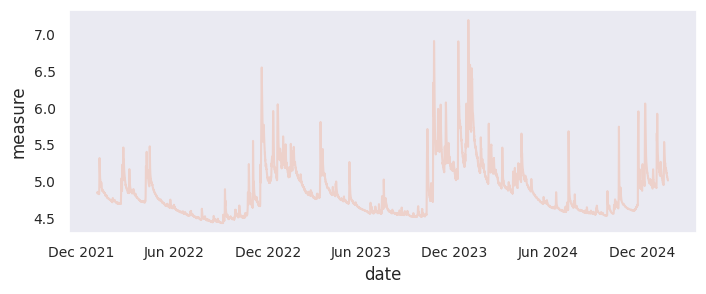

In [13]:
locating = mdates.MonthLocator(interval=6)
formatting = mdates.DateFormatter('%b %Y')

fig = plt.figure(figsize=(8.1, 2.9))
handle = fig.gca()
handle.tick_params(axis='both', labelsize='small')

sns.lineplot(data=sequence, x='date', y='measure', hue='station_id', ax=handle)

handle.xaxis.set_major_locator(locating)
handle.xaxis.set_major_formatter(formatting)

handle.get_legend().remove()

<br>
<br>

## PACF

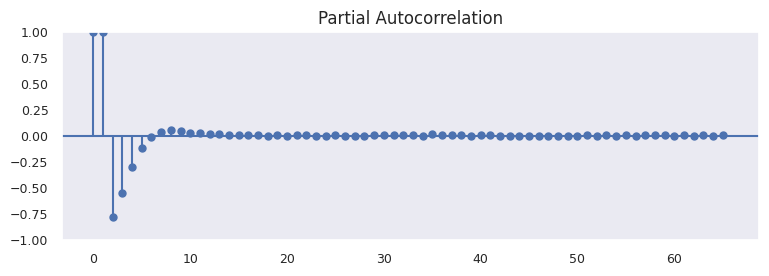

In [14]:
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)
fig, ax = plt.subplots(1, 1, figsize=(9.0, 2.7))

sa.graphics.tsa.plot_pacf(x=sequence['measure'], alpha=0.05, lags=65, ax=ax)
plt.show()

In [15]:
vectors = stst.pacf(x=sequence['measure'], nlags=65, alpha=0.05)

In [16]:
partials = pd.DataFrame(data=np.hstack((vectors[0][...,None], vectors[1])), columns=['pacf', 'l_boundary', 'u_boundary'])
partials.head()

,pacf,l_boundary,u_boundary
0,1.000000,1.000000,1.000000
1,0.999970,0.993983,1.005956
2,-1.025313,-1.031300,-1.019326
3,0.533990,0.528003,0.539977
4,-2.668536,-2.674522,-2.662549


<br>
<br>

## Decomposition Inspection

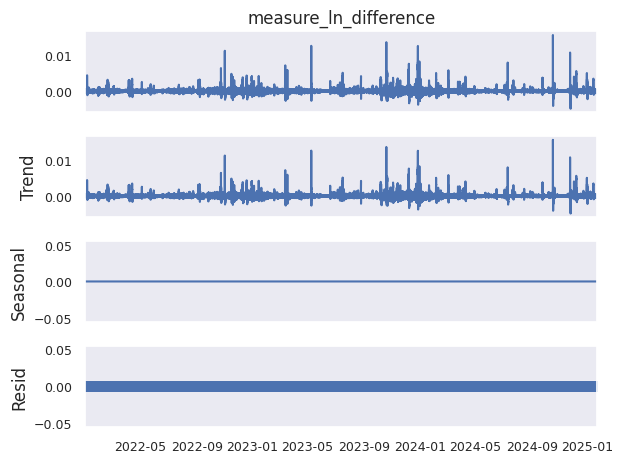

In [17]:
graphs = stsl.seasonal_decompose(x=sequence['measure_ln_difference'][1:], model='additive', period=1)
graphs.plot()
plt.show()

<br>
<br>

# Features Engineering

In [18]:
class Features:

    def __init__(self) -> None:

        self.__lags = 1

    def __ln(self, blob: pd.DataFrame):

        blob['measure_ln'] = np.log(blob['measure'].to_numpy())
        blob['measure_ln_difference'] = blob['measure_ln'].diff(periods=self.__lags)

        return blob

    def exc(self, dataset: pd.DataFrame):

        return self.__ln(blob=dataset.copy())


In [19]:
features = Features()

In [20]:
extending = []
for code in frame['station_id'].unique():

    sequence = frame.copy().loc[frame['station_id'] == code, :]
    sequence = features.exc(dataset=sequence)
    extending.append(sequence)

    del sequence

extended = pd.concat(extending, axis=0, ignore_index=True)

del extending


In [21]:
extended.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643071 entries, 0 to 643070
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   timestamp              643071 non-null  int64         
 1   value                  643071 non-null  float64       
 2   quality_code           643071 non-null  int64         
 3   station_id             643071 non-null  int64         
 4   catchment_id           643071 non-null  int64         
 5   catchment_size         643071 non-null  float64       
 6   gauge_datum            643071 non-null  float64       
 7   on_river               643071 non-null  int64         
 8   date                   643071 non-null  datetime64[ns]
 9   measure                643071 non-null  float64       
 10  measure_ln             643071 non-null  float64       
 11  measure_ln_difference  643065 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(5)
m

In [22]:
extended.sort_values(by=['station_id', 'timestamp'], ascending=True, inplace=True, ignore_index=True)

In [23]:
extended[['timestamp', 'station_id', 'catchment_id', 'date', 'measure', 'measure_ln', 'measure_ln_difference']].head()

,timestamp,station_id,catchment_id,date,measure,measure_ln,measure_ln_difference
0,1640995200000,37196,277182,2022-01-01 00:00:00,8.789,2.173501,NaN
1,1640996100000,37196,277182,2022-01-01 00:15:00,8.788,2.173387,-0.000114
2,1640997000000,37196,277182,2022-01-01 00:30:00,8.787,2.173273,-0.000114
3,1640997900000,37196,277182,2022-01-01 00:45:00,8.786,2.173160,-0.000114
4,1640998800000,37196,277182,2022-01-01 01:00:00,8.783,2.172818,-0.000342


<br>
<br>

## Graphing

Options:
* handle.get_legend().remove()

In [27]:
locating = mdates.MonthLocator(interval=12)
formatting = mdates.DateFormatter('%b %Y')

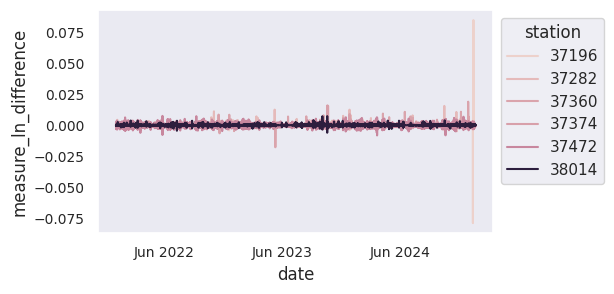

In [28]:
fig = plt.figure(figsize=(5.1, 2.9))
handle = fig.gca()
handle.tick_params(axis='both', labelsize='small')

sns.lineplot(data=extended, x='date', y='measure_ln_difference', hue='station_id', ax=handle)

handle.xaxis.set_major_locator(locating)
handle.xaxis.set_major_formatter(formatting)

handle.legend(title='station', bbox_to_anchor=(1, 1), loc='upper left')


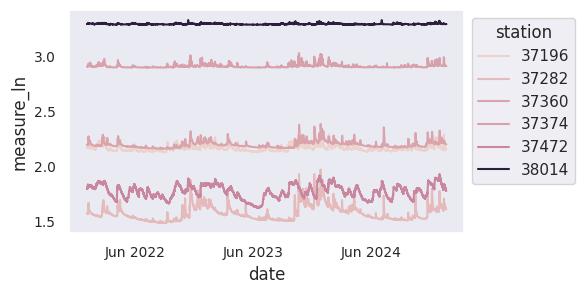

In [29]:
fig = plt.figure(figsize=(5.1, 2.9))
handle = fig.gca()
handle.tick_params(axis='both', labelsize='small')

sns.lineplot(data=extended, x='date', y='measure_ln', hue='station_id', ax=handle)

handle.xaxis.set_major_locator(locating)
handle.xaxis.set_major_formatter(formatting)

handle.legend(title='station', bbox_to_anchor=(1, 1), loc='upper left')


<br>
<br>

# Modelling

## Settings

In [30]:
class Config:
    """
    Config
    """

    def __init__(self) -> None:

        '''
        For configurations repository
        '''

        # Seed
        self.seed = 5

        # The training/testing cut-off point
        datestr = datetime.datetime.strptime('2025-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
        self.cutoff = 1000 * time.mktime(datestr.timetuple())


In [31]:
configurations = Config()

<br>
<br>

## Co&ouml;rdinates, etc.

In [32]:
extended.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643071 entries, 0 to 643070
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   timestamp              643071 non-null  int64         
 1   value                  643071 non-null  float64       
 2   quality_code           643071 non-null  int64         
 3   station_id             643071 non-null  int64         
 4   catchment_id           643071 non-null  int64         
 5   catchment_size         643071 non-null  float64       
 6   gauge_datum            643071 non-null  float64       
 7   on_river               643071 non-null  int64         
 8   date                   643071 non-null  datetime64[ns]
 9   measure                643071 non-null  float64       
 10  measure_ln             643071 non-null  float64       
 11  measure_ln_difference  643065 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(5)
m

In [33]:
extended[['timestamp', 'station_id', 'catchment_id', 'date', 'measure_ln_difference']].head()

,timestamp,station_id,catchment_id,date,measure_ln_difference
0,1640995200000,37196,277182,2022-01-01 00:00:00,NaN
1,1640996100000,37196,277182,2022-01-01 00:15:00,-0.000114
2,1640997000000,37196,277182,2022-01-01 00:30:00,-0.000114
3,1640997900000,37196,277182,2022-01-01 00:45:00,-0.000114
4,1640998800000,37196,277182,2022-01-01 01:00:00,-0.000342


<br>
<br>

## By Catchment

In [34]:
extended[['station_id', 'catchment_id']].drop_duplicates()

,station_id,catchment_id
0,37196,277182
107155,37282,277149
214338,37360,277149
321521,37374,277182
428704,37472,277187
535887,38014,277187
